In [2]:
from random import sample

# 常规导包
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants.codata2018 import alpha
from scipy.signal import welch, firwin2, fftconvolve,stft,filtfilt
from scipy.io import savemat,loadmat
from scipy.interpolate import interp1d
# from scipy.sparse.linalg.tests.test_expm_multiply import estimated


In [3]:
def generate_target_psd_noise(filter_order,samples,psd,noise,freq_vec):
    b = firwin2(filter_order + 1,freq_vec/(samples/2) ,np.sqrt(psd))
    output_noise = np.sqrt(samples)* fftconvolve(b,noise)
    return output_noise
def innerprodpsd(xVec,yVec,sampFreq,psdVals):
    nsamples  = len(xVec)
    if len(yVec) !=nsamples:
        raise  ValueError('Vectors must be of the same length')
    kNyq = nsamples //2
    psdVals = psdVals[:kNyq]
    if len(psdVals)  != kNyq:
        raise ValueError('PSD values must be specified at positive  DFT  freqencies')
    fftX = np.fft.fft(xVec)
    fftY = np.fft.fft(yVec)
    
    negFStrt = 1- (nsamples % 2)
    psdVec4Norm = np.concatenate((psdVals,psdVals[kNyq  - negFStrt::-1][0:]))
    dataLen = sampFreq* nsamples
    innProd  = (1 / dataLen) * np.dot(fftX/ (psdVec4Norm[:len(fftX)] + 1e-35),np.conj(fftY))
    innProd = np.real(innProd)
    return innProd
    

## SIS Model波形
#### 波形公式
- 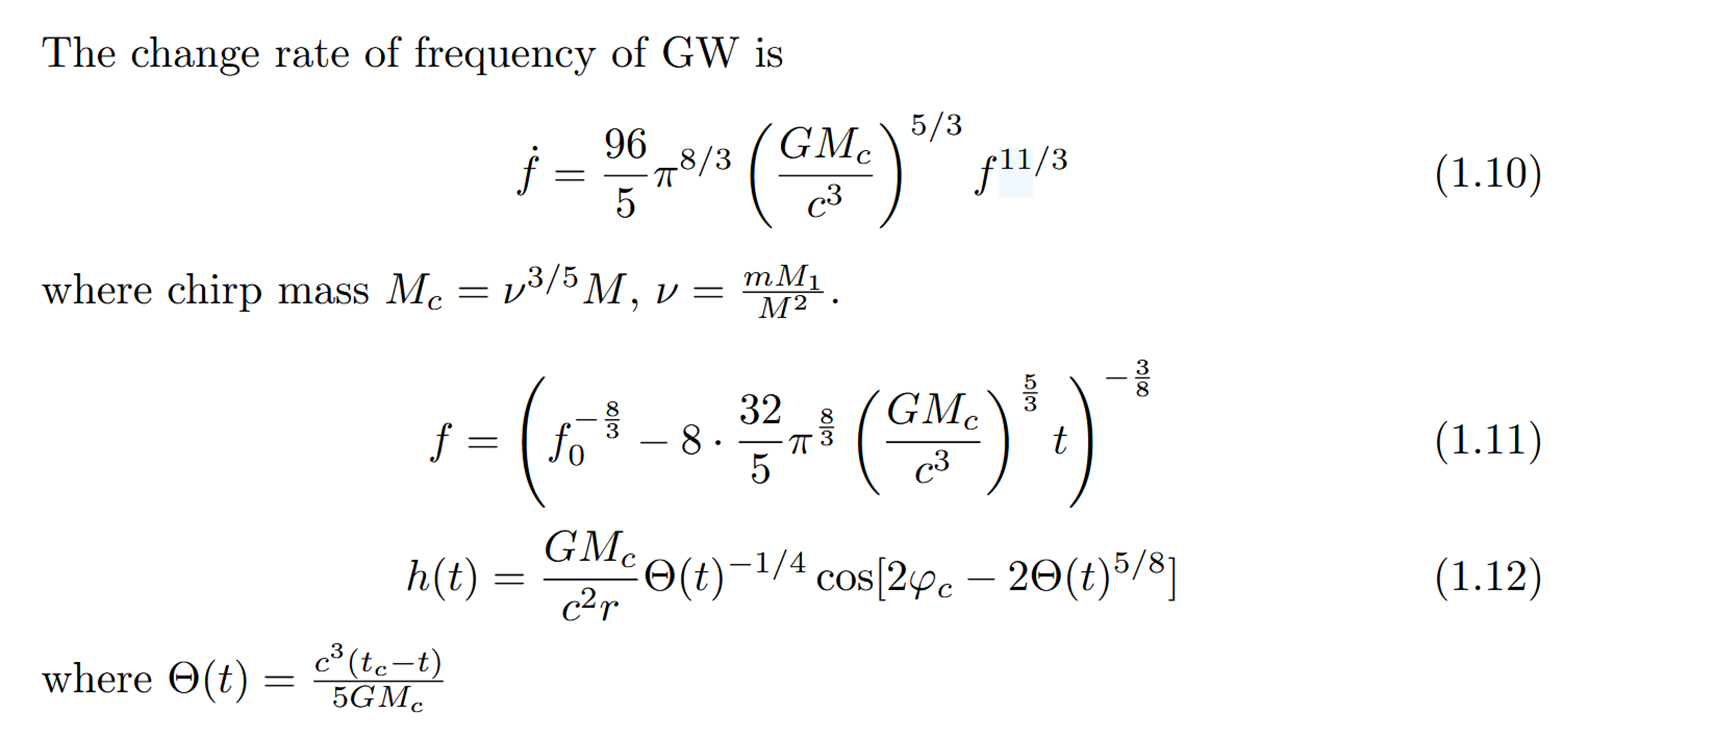
#### 透镜公式
- 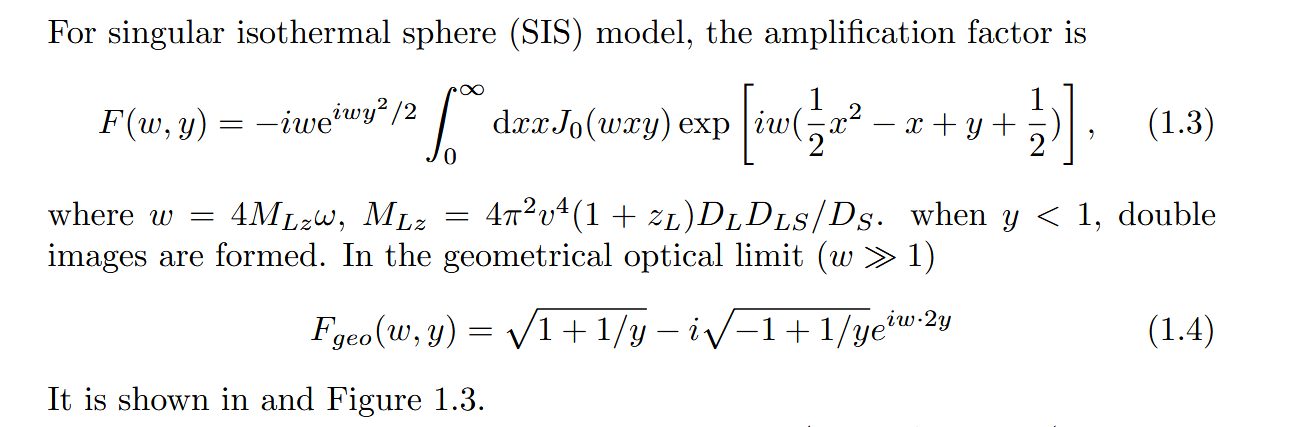
#### 待观测数据
- 所需探测范围
    - 信号：
        - r:
        - Mc:
        - tc: 
        - phi_c: 
    - 透镜：
        - Mlz:
        - y:

[0.0000e+00 5.0000e-02 1.0000e-01 ... 9.9990e+02 9.9995e+02 1.0000e+03]


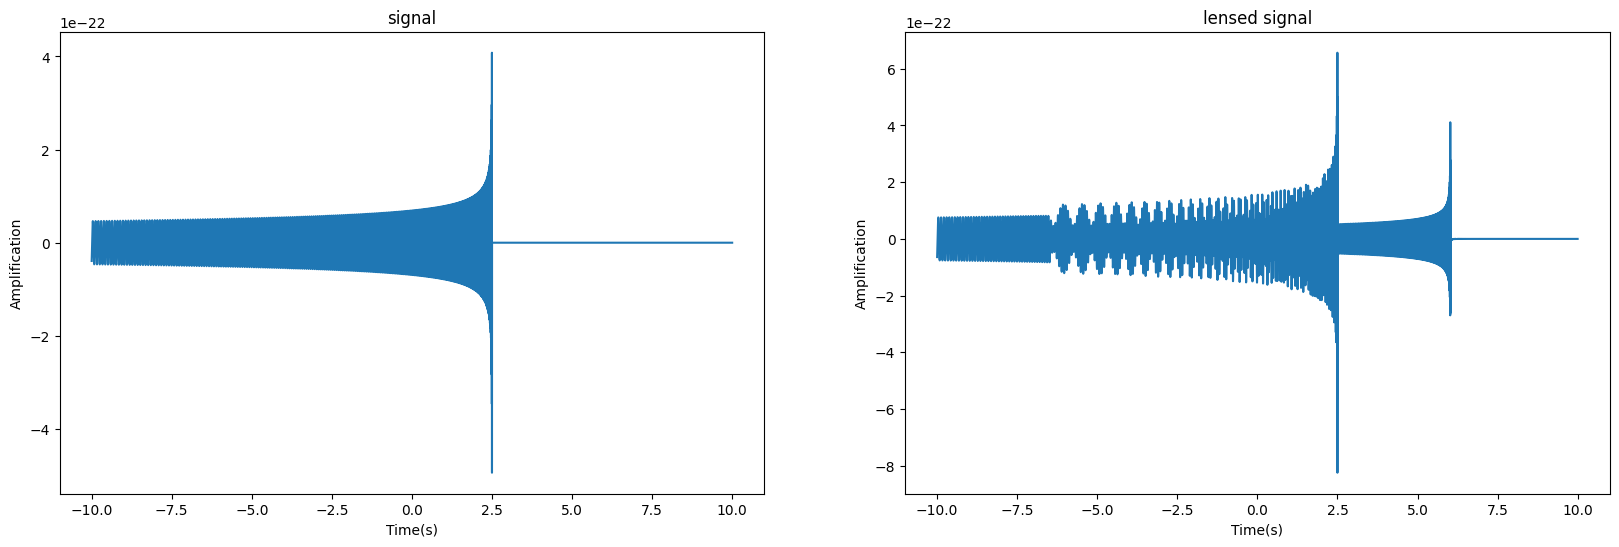

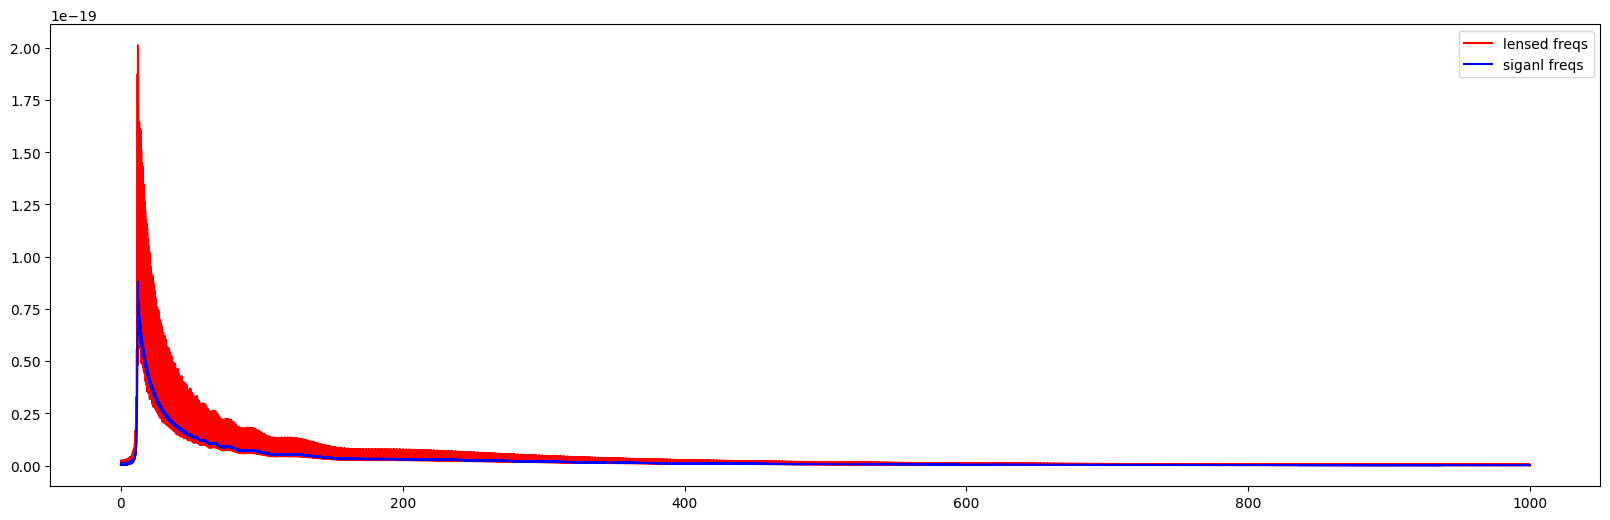

In [4]:
# 生成SIS模型波形

# 常量定义
# nsamples = 200000
# samples = 20000
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

# 变量定义
# 定义质量变量
M1 = 10 * M_sun
M2 = 25 * M_sun
M = (M1 + M2)
v = M1 * M2 / M ** 2 # 质量比
M_c = v ** (3 / 5) * M  # 啁啾质量
r = 1000 *1e6 * pc # 引力波源到观测者的距离  单位Mpc
t_c = 2.5 # 合并时间
phi_c = 1 * np.pi # 合并时刻的相位

# t = np.linspace(-100,0,30000)
# 采样率2000HZ  总样本数20w(放弃了，算不过来，光噪声一个epoch就要3小时)
# 现在这个总时长20s，采样率2000Hz，样本数4w
deltaT = 0.0005
t = np.arange(-10,10,deltaT) 

# 定义引力波信号函数
def generate_h_t(t,M_c,r,phi_c):
    if t < t_c:
        theta_t= c**3 *(t_c - t) / (5 * G * M_c)
        h = G * M_c /(c ** 2 * r) * theta_t**(-1/4)*np.cos(2*phi_c - 2*theta_t**(5/8)) # r控制信号振幅大小，r越大，振幅越小
    else :
        h = 0
    return h
generate_h_t = np.frompyfunc(generate_h_t,4,1)
# 生成信号
h = generate_h_t(t,M_c,r,phi_c).astype(float)

# h = h[:-1]
# t = t[:-1]
# 去掉信号inf的情况
# 将信号转换到频域
h_f = np.fft.rfft(h)

# 生成频率
freqs = np.fft.rfftfreq(len(h),t[1] - t[0])
print(freqs)
# 透镜参数定义
Mlz = 1e7* M_sun
omega = 2 * np.pi * freqs
w = G * 4 *Mlz * omega / c**3
y = 0.6

# 定义光学极限的透镜化SIS模型
def generate_f_geo(w,y):
    if y <1 : 
        F_geo = np.sqrt(1 + 1/y) - 1j * np.sqrt(-1 + 1 / y) * np.exp(1j * w * 2 * y)
    else :
        F_geo = np.sqrt(1 + 1 / y)
    return F_geo
# 生成透镜化，频域
F_geo = generate_f_geo(w,y)

# h_lens = h * F_geo
# 将信号透镜化 （频域）
lens_f = h_f * F_geo
# 逆傅里叶变换将频域信号转换为时域信号
h_lens = np.fft.irfft(lens_f)

# # 画图
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(t,h.real,label = 'signal')
plt.xlabel('Time(s)')
# plt.xlim(-5,10)
plt.ylabel('Amplification')
plt.title('signal')
# t = t[:-1]
plt.subplot(1,2,2)
plt.plot(t,h_lens,label = 'lensed signal')
plt.xlabel('Time(s)')
# plt.xlim(-2.5,5)
# plt.ylim(-0.5e-19,0.5e-19)
plt.ylabel('Amplification')
plt.title('lensed signal')


plt.show()


plt.figure(figsize=(20,6))
plt.plot(freqs,np.abs(lens_f),'red',label = 'lensed freqs')
plt.plot(freqs,np.abs(h_f),'blue',label = 'siganl freqs')
plt.legend()
# plt.yscale('log')
plt.show()
# print(np.isinf(h_lens).any())


## LIGO提供的PSD相关数据

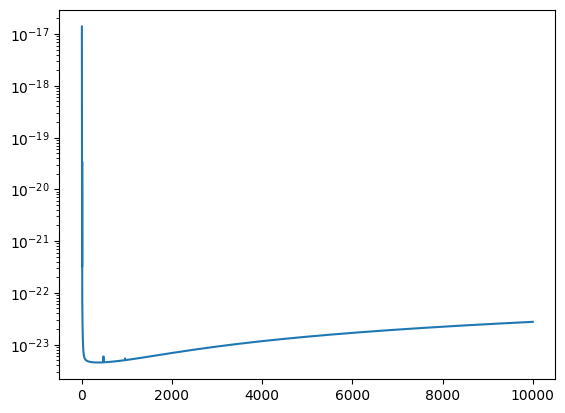

In [5]:
# 获取频率和噪声功率谱密度
freq_psd = np.loadtxt('aligo_design.txt')
posfreqs = freq_psd[:,0]
psd_txt = freq_psd[:,1]
plt.plot(posfreqs,psd_txt)
plt.yscale('log')

/home/ywq/anaconda3/envs/Ubuntu/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


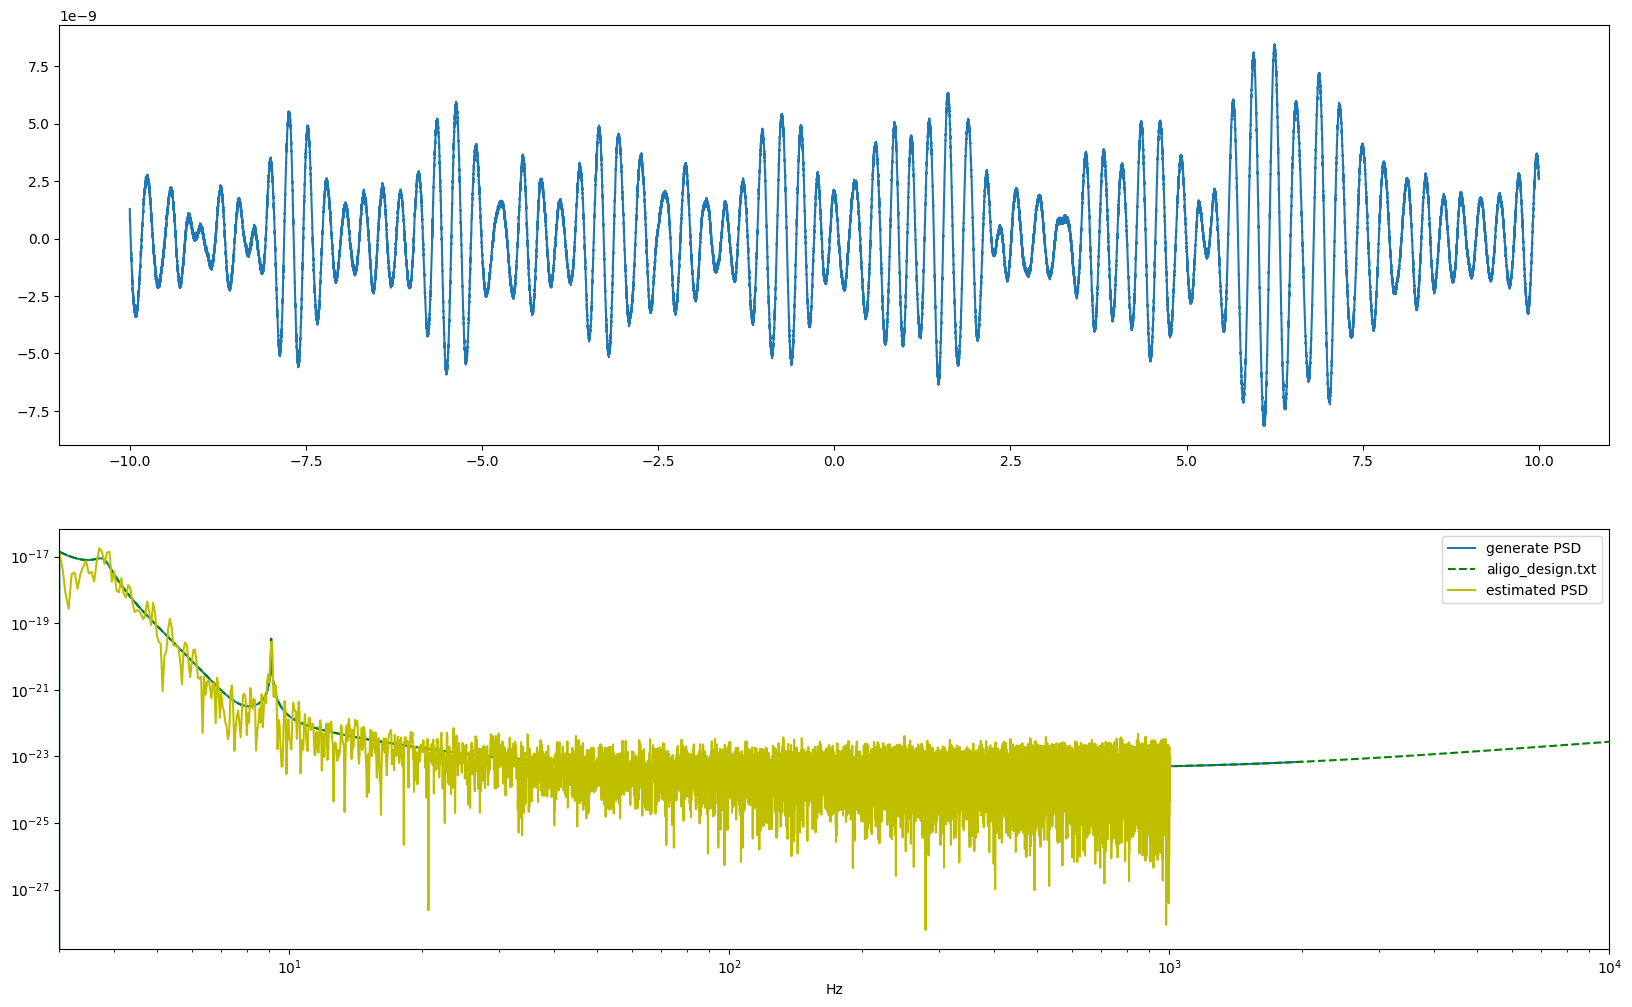

In [6]:
import pycbc.psd
import pycbc.noise
import pycbc.types
filename = 'aligo_design.txt'


delta_f = 1.0 / 20
samples = 2000
length = int(samples / delta_f)
low_frequency_cutoff = 3.0
# The PSD will be interpolated to the requested frequency spacing(按照要求的频率间隔进行插值)
# 如果是asd，则进行平方操作
psd = pycbc.psd.from_txt(filename, length, delta_f,
                         low_frequency_cutoff, is_asd_file=False)
fig = plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
delta_t = 1/samples 
outNoise = pycbc.noise.noise_from_psd(length, delta_t, psd,seed = 516)

estimated_psd = pycbc.psd.welch(outNoise,int(20/delta_t),int(20/delta_t/2))
plt.plot(t,outNoise,label = 'signal')
plt.subplot(2,1,2)
plt.loglog(psd.sample_frequencies, psd, label='generate PSD')
plt.xlim(xmin=3, xmax=10000)
plt.loglog(posfreqs,psd_txt, 'g--',label='aligo_design.txt')
plt.yscale('log')
plt.xlabel('Hz')
plt.plot(estimated_psd.sample_frequencies,estimated_psd,'y',label='estimated PSD')
plt.legend()
plt.show()


In [7]:
# # 这个是不是跟滤波器的一样啊
# np.random.seed(516)
# initial_noise = np.random.normal(0,1,nsamples)
# filter_order = 300
# freqs = np.linspace(0,samples/2,3000)
# output_noise = generate_target_psd_noise(filter_order=filter_order,samples=samples,psd=psd,noise=initial_noise,freq_vec=freqs)
# 
# f,pxx = welch(output_noise,fs = samples,nperseg=samples)
# 
# # 看下频域
# f_noise = np.fft.rfft(output_noise)
# f_freqs = np.fft.rfftfreq(len(output_noise),t[1]-t[0])
# 
# 
# fig = plt.figure(figsize=(18,12))
# plt.subplot(311)
# output_noise = output_noise[:len(t)]
# plt.plot(t,output_noise)
# 
# 
# plt.subplot(312)
# plt.plot(posfreqs,psd,'r--',label = 'aLIGO')
# plt.plot(f,pxx,'b',label = 'generate')
# plt.yscale('log')
# plt.xlim(0,500)
# # plt.xscale('log')
# plt.legend()
# 
# plt.subplot(313)
# plt.plot(f_freqs,np.abs(f_noise))
# plt.yscale('log')
# plt.show()
# 


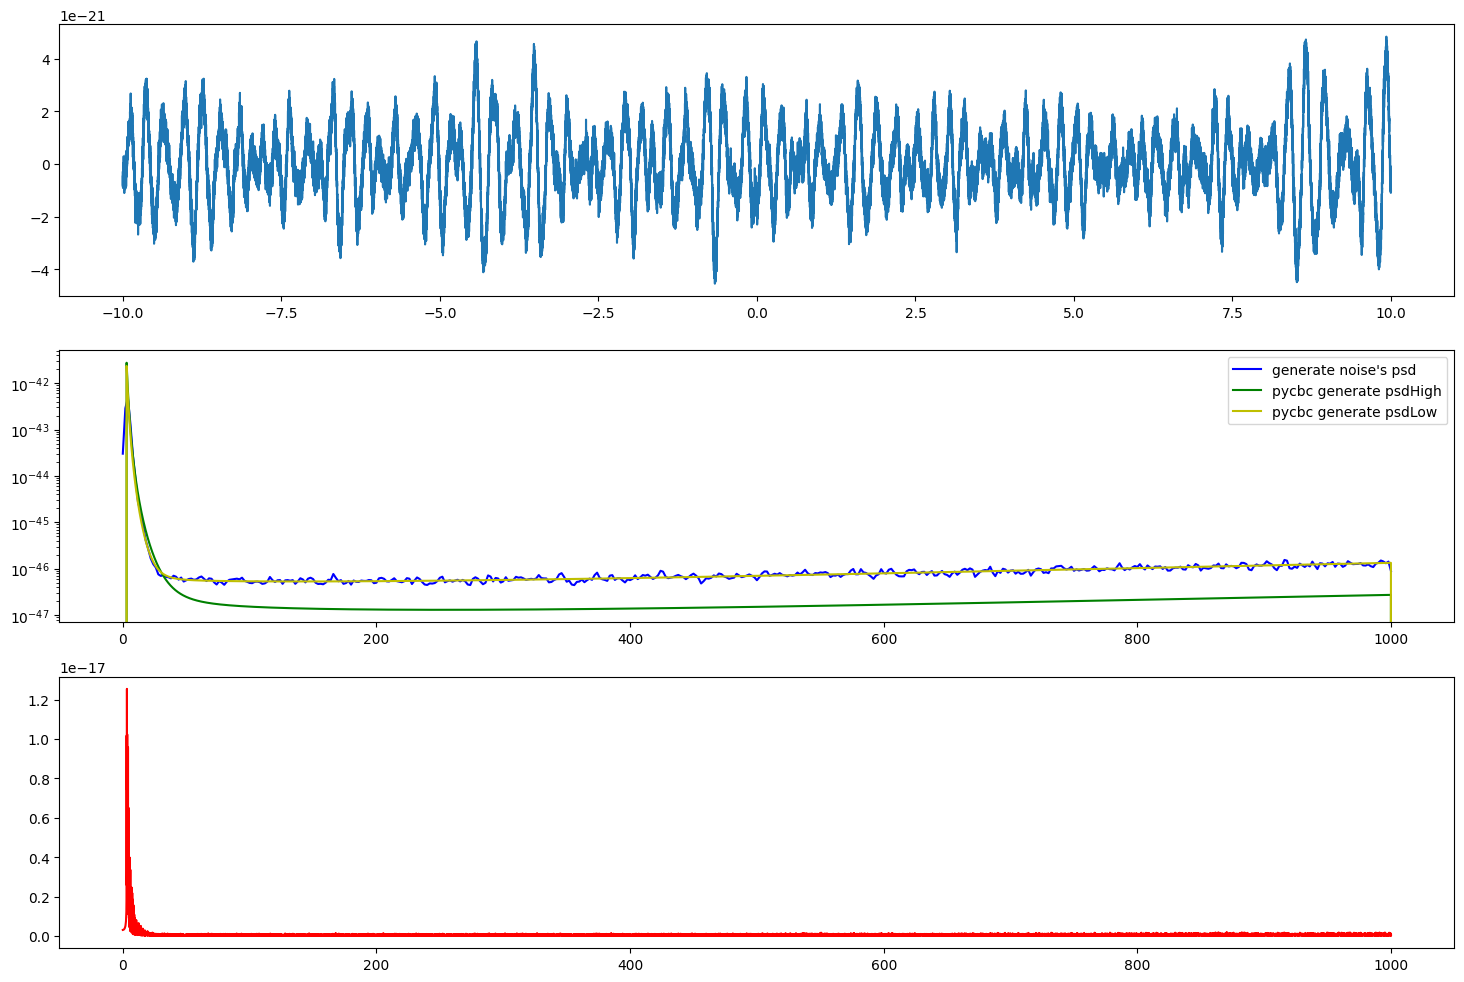

In [8]:
import matplotlib.pyplot as plt
import pycbc.noise
import pycbc.psd
import numpy as np
from scipy.signal import welch

# psd 参数
flow = 3 # 最低频率为3Hz
delta_f = 1.0 / 20 # 频率分辨率
nyq_freq = 1000
flen = int(nyq_freq / delta_f) + 1
# 生成两种PSD的两种方式
psdHigh = pycbc.psd.aLIGOZeroDetHighPower(flen,delta_f,flow)

psdLow = pycbc.psd.from_string('aLIGOZeroDetLowPower',flen,delta_f,flow)
# psd = psdHigh + psdLow
# 噪声参数
delta_t = 1.0 / 2000
tsamples = 40000
duration = tsamples * delta_t
samples = tsamples / duration

outNoise = pycbc.noise.noise_from_psd(tsamples,delta_t,psdLow,seed= 123)
freqs = np.fft.rfftfreq(len(outNoise),t[1]-t[0])

f,pxx = welch(outNoise,fs = samples,nperseg=samples/2)
f_noise = np.fft.rfft(outNoise)
plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(t,outNoise)

plt.subplot(312)
plt.plot(f,pxx,'b',label = "generate noise's psd")
# plt.plot(freqs,psd,'r',label = "psd = psdHigh + psdLow")
plt.plot(freqs,psdHigh,'g',label = "pycbc generate psdHigh")
plt.plot(freqs,psdLow,'y',label = "pycbc generate psdLow")
plt.yscale('log')
plt.legend()
# plt.xscale('log')
plt.subplot(313)
plt.plot(freqs,np.abs(f_noise),'r')
plt.show()
savemat('noise.mat',{'noise':outNoise})

# 将噪声混入信号
- 左图为透镜化之后的信号以及噪声情况
- 右图为透镜化之后的信号与混合数据的情况
- 取值情况为噪声约为信号的10-100倍强度
## 之后用数据代指       透镜化信号+噪声

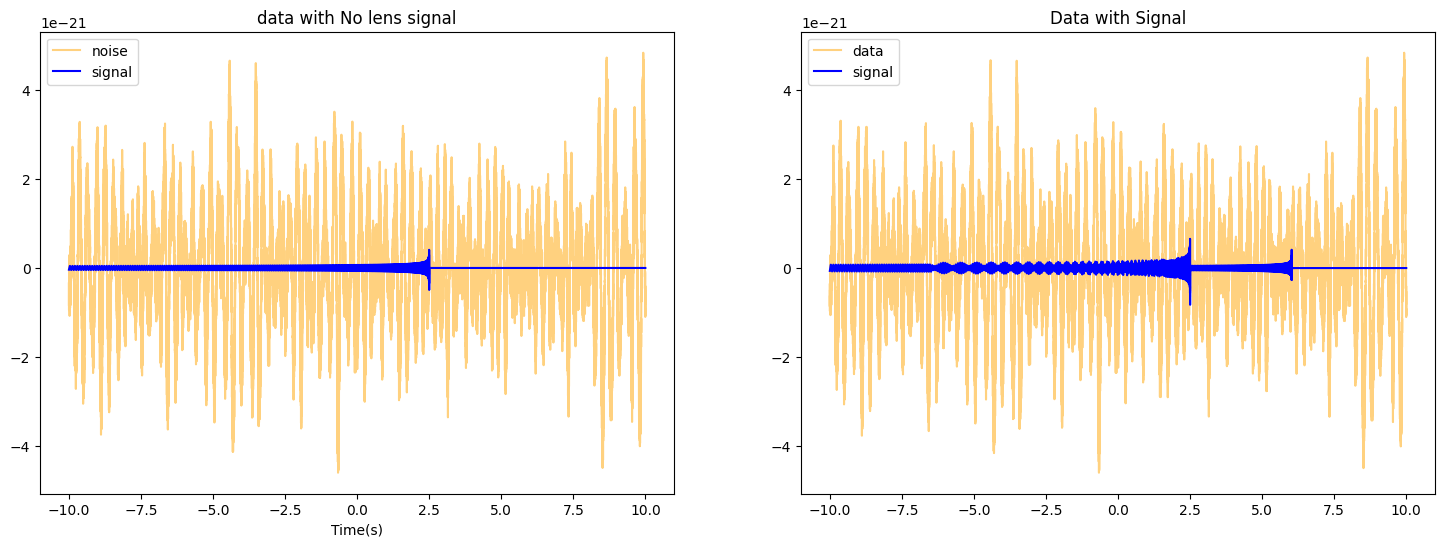

In [9]:
# h = h[:len(output_noise)]
# data = h + output_noise

data = h_lens + outNoise
data_no_lens = h + outNoise

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# 第一个子图
axs[0].plot(t, data_no_lens, "orange", label="noise", alpha=0.5)
axs[0].plot(t, h, "blue", label='signal')
axs[0].set_xlabel("Time(s)")
axs[0].set_title("data with No lens signal")
axs[0].legend()

# 第二个子图
axs[1].plot(t, data, "orange", label="data", alpha=0.5)
axs[1].plot(t, h_lens, "blue", label='signal')
axs[1].set_title("Data with Signal")
axs[1].legend()

plt.show()

savemat('data.mat',{'data':data,'samples':samples})
savemat('data_No_lens.mat',{'data':data_no_lens,'samples':samples})
# print(np.isinf(data).any())

# 绘制噪声与数据的功率谱密度
- 蓝色线代表总数据
- 橙色线代表纯噪声


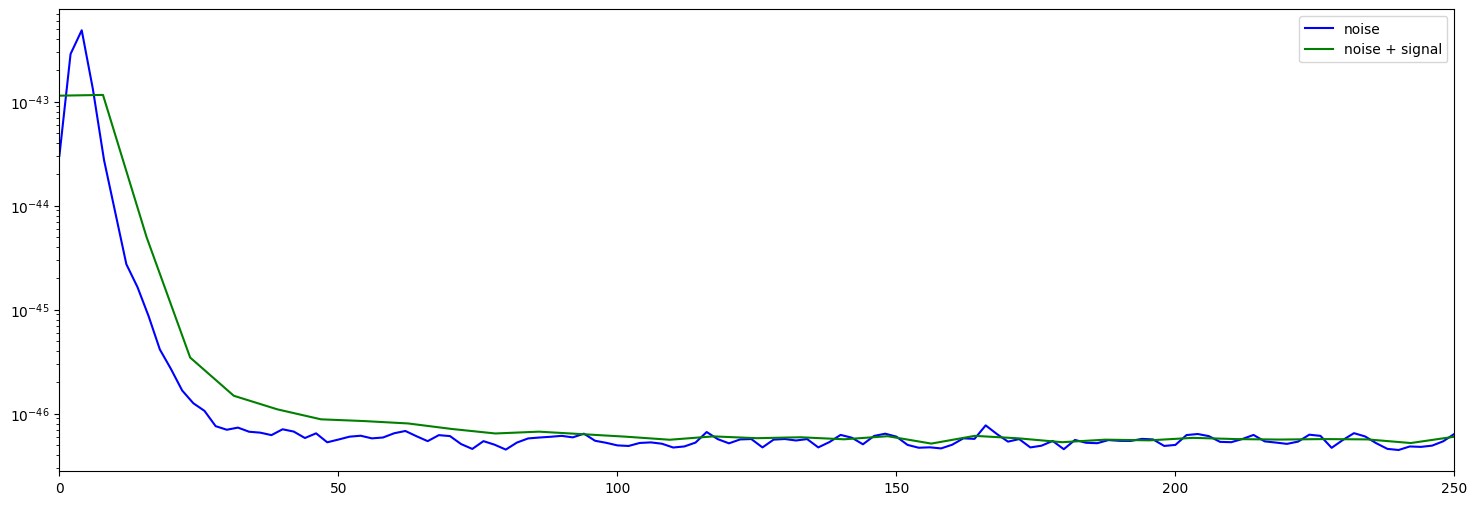

In [10]:
[f_data,pxx_data] = welch(data,fs = samples,window = "hamming",nperseg=256,noverlap=None,nfft=None,detrend = False)

fig = plt.figure(figsize=(18,6))
plt.plot(f,pxx,'blue',label = 'noise')
plt.plot(f_data,pxx_data,"green",label = 'noise + signal')
plt.yscale('log')
plt.legend()
plt.xlim(0,250)
plt.show()

In [11]:
# 查看数据是否可以调用
# data = loadmat("data.mat")
# noise = loadmat("noise.mat")

# samples_data = data['samples'][0]
# dataY = data['data'][0]
# noise_y = noise['noise'][0]
# dataY_FFT = np.fft.fft(dataY)
# print(np.any(np.isinf(dataY_FFT)))

## 信噪比
- 在学习信噪比时看到的一个很好理解的视频
    - https://www.bilibili.com/video/BV1NG411b7qD/?spm_id_from=333.1391.0.0&vd_source=6653954c04b5fa19db6e649a79e0d4dd

In [12]:
# # 计算信噪比
# print(len(data),len(h_lens),len(outNoise))
# llrH0 = np.zeros(1000)
# for lp in range(len(llrH0)):
#     llrH0[lp] = innerprodpsd(outNoise,h_lens,samples,freqs)
# llrH1 = np.zeros(1000)
# for lp in range(len(llrH1)):
#     llrH1[lp] = innerprodpsd(data,h_lens,samples,freqs)

# estSNR = (np.mean(llrH1) - np.mean(llrH0)) / np.std(llrH0)

# print(estSNR)


In [13]:
print(f"r: {r / 1e6 / pc:.4e} m_c: {M_c/M_sun:.4f} t_c: {t_c} phi_c: {phi_c / np.pi} Mlz: {Mlz/M_sun:.4e} y: {y}")

r: 1.0000e+03 m_c: 13.4881 t_c: 2.5 phi_c: 1.0 Mlz: 1.0000e+07 y: 0.6
